In [1]:
 import sys
sys.path.insert(0, '../../../network')
sys.path.insert(0, '../../../figures')
from sequences import GaussianSequence
from transfer_functions import ErrorFunction
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from learning import ReachingTask
import pandas as pd
from tqdm import tqdm, trange
import matplotlib
import matplotlib as mpl
from scipy import stats

In [2]:
# Set font family globally
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
font = {'family' : 'arial',
        'weight' : 'light',
        'size'   : 18}

matplotlib.rc('font', **font)

mpl.rcParams['axes.linewidth'] = 2

# Filename and Directory

In [3]:
filename = 'figure'
path = '/work/jp464/striatum-sequence/' + filename + '.npz'
data = np.load(path) 
overlaps_ctx = data['overlaps_ctx']
overlaps_d1 = data['overlaps_d1']
# values = data['values']
# rpes = data['rpes']
# correlations_ctx = data['correlations_ctx']
# correlations_bg = data['correlations_bg']
state_ctx = data['state_ctx']
state_d1 = data['state_d1']
evars = data['evars']

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

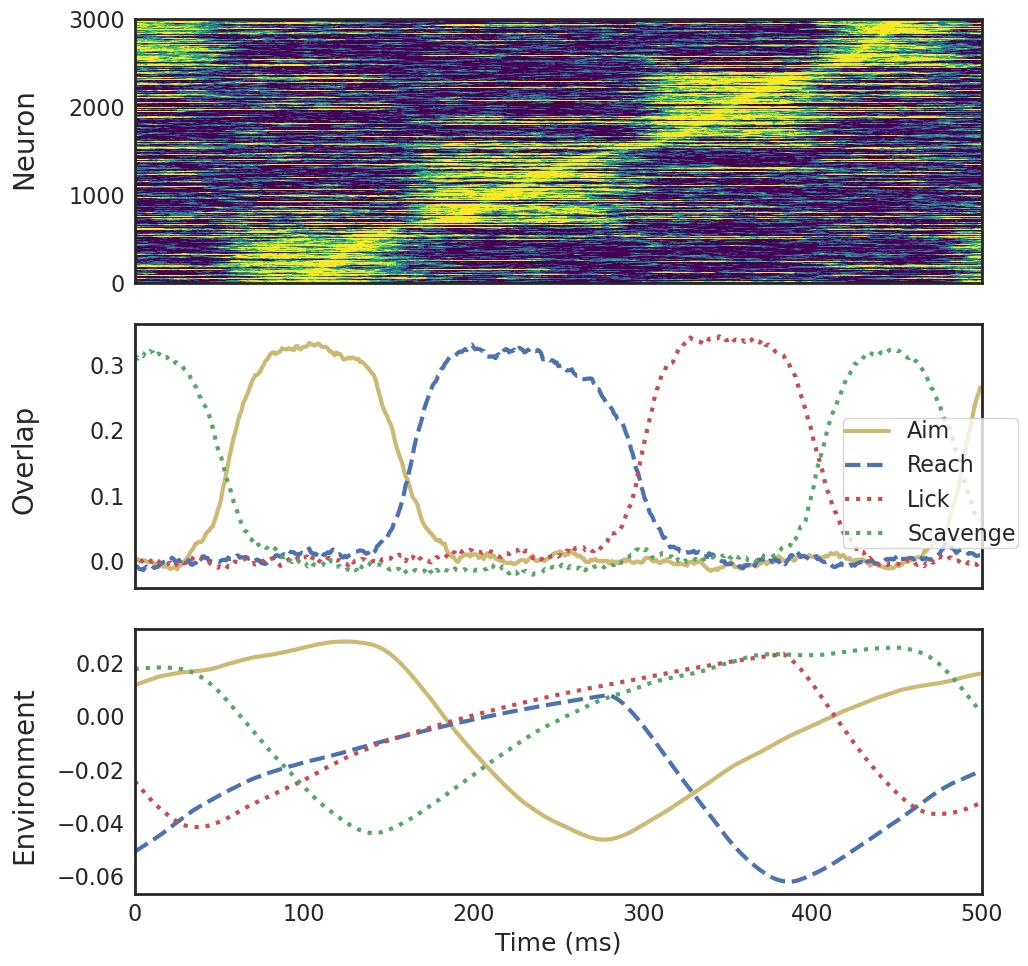

In [284]:
### Raster plot 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, tight_layout=True, figsize=(10,10))
idxs = np.argsort([np.argmax(r) for r in state_d1[:,2400:2750]])
idxs = [i for i in idxs if state_d1[:,2400:2750][i].max() > 0.00]
seg_state = state_d1[:,2300:2800]
axes[0].pcolormesh(seg_state[idxs], vmin=0.0, vmax=1.0, cmap='viridis', rasterized=True)
seg_overlaps_d1 = overlaps_d1[:,2300:2800]
axes[1].plot(seg_overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(seg_overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(seg_overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(seg_overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
seg_evars = evars[:,2300:2800]
axes[2].plot(seg_evars[0], linestyle='solid', linewidth=3, color=colors[8])
axes[2].plot(seg_evars[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[2].plot(seg_evars[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[2].plot(seg_evars[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[2].set_xlabel('Time (ms)')
fig.text(-.02, .8, 'Neuron', rotation='vertical', fontsize=20)
fig.text(-.02, .475, 'Overlap', rotation='vertical', fontsize=20)
fig.text(-.02, .125, 'Environment', rotation='vertical', fontsize=20)
filename = 'segregated-population'
plt.savefig('/work/jp464/striatum-sequence/output/' + filename + '-raster' + '.svg', bbox_inches="tight", format='svg')
plt.figlegend(labels=['Aim', 'Reach', 'Lick', 'Scavenge'], fontsize=16, borderpad=0.1, loc='center right')
plt.show()

### Learning rate

### Phase diagram

In [158]:
def infer(A, k):
    for x in range(A.shape[0]):
        for y in range(A.shape[1]):
            if A[x,y] != 0: continue
            seq, att = 0, 0
            cnt = 0
            for i in np.arange(-k,k+1,1):
                for j in np.arange(-k,k+1,1):
                    if x + int(i) < 0 or y + int(j) < 0 or (x+int(i)) >= A.shape[0] or y+int(j) >= A.shape[1]: continue
                    score = A[x+int(i),y+int(j)]
                    if score == 2:
                        seq += 1
                    elif score == 1:
                        att += 1
                    cnt += 1
            if max(seq, att) < cnt/2-1: continue
            if seq > att:
                val = 2
            elif seq < att:
                val = 1
            else:
                val = 0
            A[x][y] = val

def polish(A,k):
    for x in range(A.shape[0]):
        for y in range(A.shape[1]):
            cur = A[x,y]
            cnt = 0
            wrong = np.zeros(3)
            for i in np.arange(-k,k+1,1):
                for j in np.arange(-k,k+1,1):
                    # Check boundary conditions
                    if x + int(i) < 0 or y + int(j) < 0 or (x+int(i)) >= A.shape[0] or y+int(j) >= A.shape[1]: continue
                    score = A[x+int(i),y+int(j)]
                    if cur != score:
                        wrong[score] += 1
                    cnt += 1
            if np.sum(wrong) > .6 * cnt:
                val = np.argmax(wrong)
            else: continue

            A[x][y] = val
            
def generate_matrix(df, size=61):
    ret = np.zeros((size,size), dtype='int')
    for row in df:
        idx1, idx2 = int(row[0]/0.1), int(row[1]/0.1)
        if row[2]: val = 1 
        elif row[3]: val = 2
        else: val = 0 
        ret[idx1, idx2] = val  
    for i in range(5):
        infer(ret, 1)
    polish(ret, 1)
    return ret

In [177]:
df = pd.read_hdf('/work/jp464/striatum-sequence/output/retrieval_speed.h5', 'data')
pdata1 = df[df['Acb'] == .5][['Acc', 'Abc', 'seq', 'att']].to_numpy()
pdata2 = df[df['Acb'] == 1.5][['Acc', 'Abc', 'seq', 'att']].to_numpy()
pdata3 = df[df['Acb'] == 2.5][['Acc', 'Abc', 'seq', 'att']].to_numpy()

phase1 = generate_matrix(pdata1)
phase2 = generate_matrix(pdata2)
phase3 = generate_matrix(pdata3)

Text(2, 54, 'Fixed points')

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

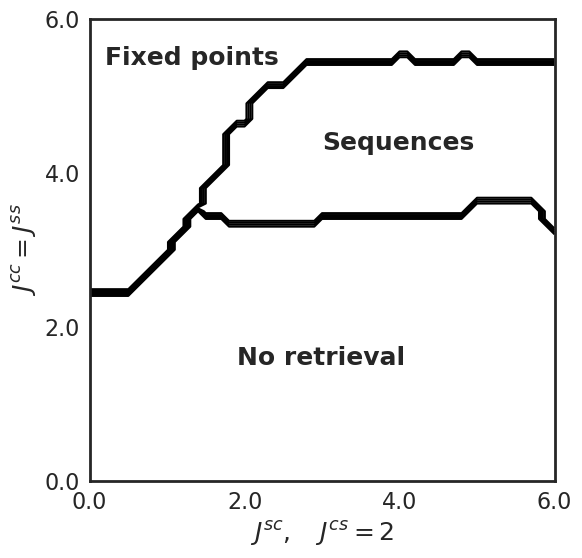

In [225]:
fig, ax = plt.subplots(figsize=(6,6))
# ax.contour(phase1, colors='black')
ax.contour(phase2, colors='k')
ax.set_xticks(np.arange(0, 61, 20), np.arange(0,6.1,2))
ax.set_yticks(np.arange(0, 61, 20), np.arange(0,6.1,2))
ax.set_xlabel(r'$J^{sc}, \quad J^{cs} = 2$')
ax.set_ylabel(r'$J^{cc} = J^{ss}$')
# ax.contour(phase3, colors='green')
plt.annotate('No retrieval',(19,15), weight='bold')
plt.annotate('Sequences',(30,43), weight='bold')
plt.annotate('Fixed points',(2,54), weight='bold')

### Clustered Population

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

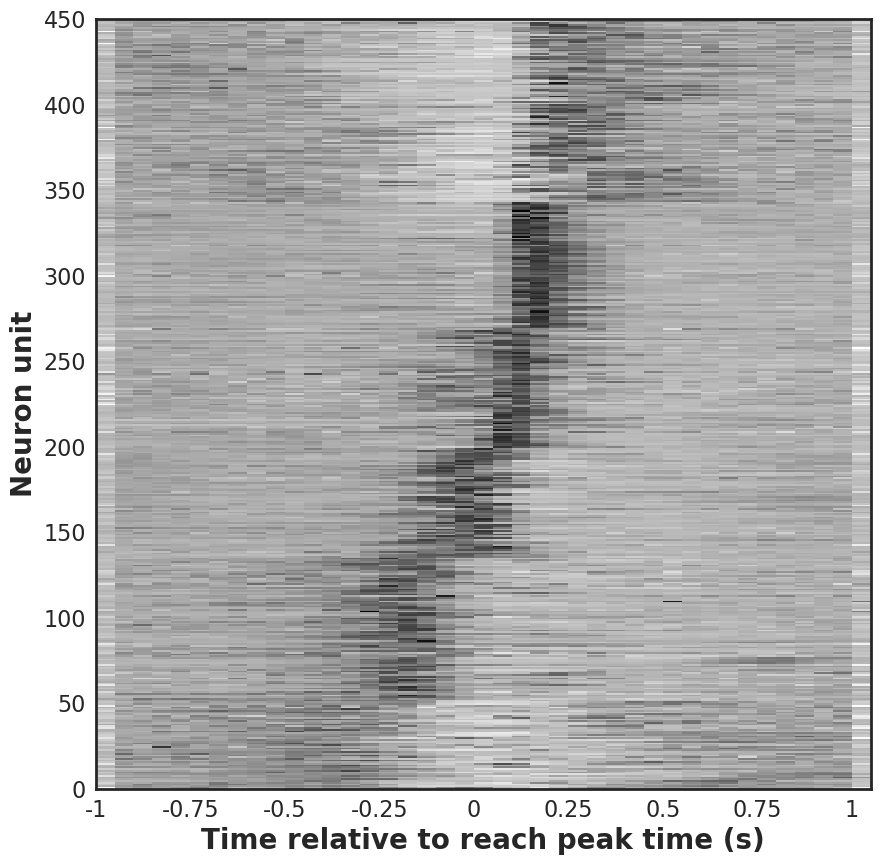

In [275]:
df = pd.read_excel('/work/jp464/striatum-sequence/output/data-clustered-population.xlsx')
time = df.iloc[1:,0].to_numpy()
time_idx = np.arange(0, len(time), 5)
group = df.iloc[0,1:].to_numpy()
mask1, mask2, mask3, mask4, mask5, mask6 = np.logical_and(group > 0.5, group < 1.5), np.logical_and(group > 1.5, group < 2.5), np.logical_and(group > 2.5, group < 3.5), np.logical_and(group > 3.5, group < 4.5), np.logical_and(group > 4.5, group < 5.5), np.logical_and(group > 5.5, group < 6.5)
group[mask1] = 5
group[mask2] = 4
group[mask3] = 2
group[mask4] = 1
group[mask5] = 3
group[mask6] = 6
neurons_idx = np.argsort(group)

data = df.iloc[1:,1:].to_numpy()
data2 = np.transpose(data[:,neurons_idx])
fig, ax = plt.subplots(figsize=[10,10])

ax.pcolormesh(data2,
          cmap='binary'
          )
ax.set_xticks(time_idx, time[time_idx])
ax.set_xlabel("Time relative to reach peak time (s)", fontsize=20, fontname="arial", weight='bold')
ax.set_ylabel("Neuron unit", fontsize=20, fontname="arial", weight='bold')
plt.show()

### Firing rate

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

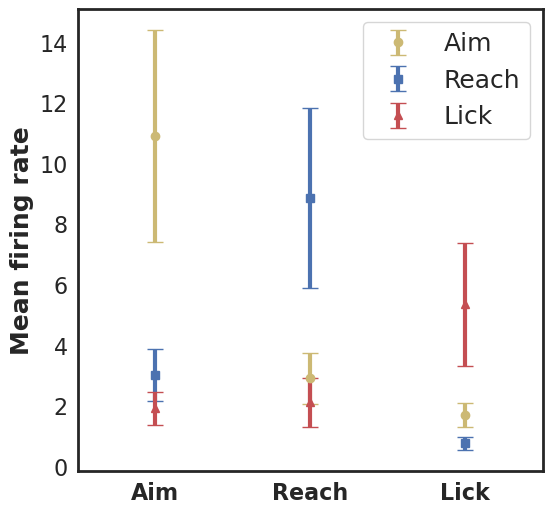

In [283]:
df = pd.read_excel('/work/jp464/striatum-sequence/output/data-firing-rate.xlsx')
aim = df.iloc[:,0:16].to_numpy()
reach = df.iloc[:,16:32].to_numpy()
lick = df.iloc[:,32:].to_numpy()
mean = np.vstack((np.mean(aim, axis=1), 
                  np.mean(reach, axis=1),
                  np.mean(lick, axis=1)))

sem = np.vstack((stats.sem(aim, axis=1), 
                  stats.sem(reach, axis=1),
                  stats.sem(lick, axis=1)))
fig, ax = plt.subplots(figsize=[6,6])
ax.errorbar([1,2,3], mean[:,0], sem[:,0], fmt='o', linewidth=3, capsize=6, label='Aim', color=colors[8])
ax.errorbar([1,2,3], mean[:,1], sem[:,1], fmt='s', linewidth=3, capsize=6, label='Reach', color=colors[0])
ax.errorbar([1,2,3], mean[:,2], sem[:,2], fmt='^', linewidth=3, capsize=6, label='Lick', color=colors[3])
ax.set_xlim(0.5,3.5)
ax.set_xticks([1,2,3], ['Aim', 'Reach', 'Lick'], weight='bold')
ax.set_ylabel('Mean firing rate', weight='bold')

plt.legend()
plt.show()